Modeling and testing grounds

In [28]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SpatialDropout2D
from keras.utils import to_categorical
from keras.models import load_model

from numpy.random import seed
from tensorflow import set_random_seed

from skimage.transform import resize

import datetime
from tqdm import tqdm_notebook
import pickle
import sys

In [2]:
# Initial setting of random seeds
seed(42)
set_random_seed(42)

In [3]:
# Checking to make sure that I am using 1+ GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()


['/job:localhost/replica:0/task:0/device:GPU:0']

## Modeling and Evaluation Functions

Writing multiple functions to facilitate creating different datasets, modeling over different datasets and/or different hyperparameters, and evaluating the different models using graphs




In [4]:
class PnemoniaTargetMapIsWeird(AssertionError):
    """Raise this when the target is not mapped to 2 or 3 outputs"""
    pass

In [5]:
def create_pic_df(data, df_detailed, image_size = (128,128)):
    
    print('---Enter DataFrame Construction Function---')
    
    ## Data Prep
    # Need to define df_detailed somewhere
    data.drop_duplicates(inplace=True)
    merged_df = df_detailed.merge(data, on='patientId')
    
    print('---Create Pixel Array Labels---')
    
    # Create the column labels for the pixel arrays
    pixel_labels = []
    for i in range(image_size[0] * image_size[1]):
        pixel_labels.append("pixel"+str(i))
    
    print('---Create Total Pixel Array---')
    
    # Create the total pixel array
    huge_pixel_array = []
    for o in tqdm_notebook(range(merged_df.shape[0])):
        # Get the image data
        patientId = merged_df.iloc[o]['patientId']
        dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
        dcm_data = pydicom.read_file(dcm_file)
        im = dcm_data.pixel_array

        # Convert the image into a 1d array of pixels
        curr_pixel_array = []
        for i in resize(im, image_size): 
            curr_pixel_array.extend(i)
        huge_pixel_array.append(curr_pixel_array)

    print('---Create Dataframe---')
        
    # Creating the DataFrame
    temp = pd.DataFrame(data = huge_pixel_array, columns = pixel_labels)
    temp['class'] = merged_df['class']
    return temp

In [40]:
def model(data, model_name = "default_model_name", image_size = (128,128), y_map = {
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}, epochs = 20, train_size = 0.75, metrics = ['accuracy'], batch_size = 10, model_optimizer = 'adam', verbose = 1):
    """
    Args:
        data (Pandas DataFrame): cols=['class', all of the pixel data]
        
        model_name (str): The name with which to save the model
        
        image_size (touple: (int,int)): The width and height in pixels to scale the images. Max 1024x1024. This might be more finickey that I would've thought.
        
        y_map (dict): A dictionary mapping the target values to integers ([0,1] or [0,1,2])
        
        epochs (int): Number of epochs to train the model over
        
        train_size (float): Denotes the percentage of data to use for training as opposed to testing. Between 0. and 1.  
        
        metrics (list): list of strings metric names with which to measure the model's performance
        
        batch_size (int): Number of images to use
        
        model_optimizer (string or optimizer object): Determines which optimizer for the model to use.
        
        verbose (int): Verbose option for model training. (0, 1, 2)
        
        
    Returns:
        Keras Model fit on the data.
        Saves the model to ../data/models/model_name datetime.h5
    """
    print('---Enter Function---')
    
    # Setting the seeds every time I do another model so that I can make sure to have reproducible results
    seed(42)
    set_random_seed(42)

    # Create target
    y = data['class']
    y = y.map(lambda x: y_map[x])
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), y, 
                                                        stratify=y, random_state=42, train_size = train_size)
    
    # Transform target into arrays of integers
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    # Reshape the X_train and X_test 
    X_train_re = X_train.values.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
    X_test_re = X_test.values.reshape(X_test.shape[0], image_size[0], image_size[1], 1)
    
    print('---Modeling Initialization---')
    
    ## Modeling
    # Initialize Model
    model_convolutional = Sequential()

    # First Conv / Pool 
    model_convolutional.add(Conv2D(filters = 8,
                                   kernel_size = 3,
                                   activation = 'relu',
                                   input_shape = (image_size[0], image_size[1], 1)
                                  ))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))
    
#    model_convolutional.add(SpatialDropout2D(0.5)) #not included

    # Second Conv/ Pool
    model_convolutional.add(Conv2D(filters=18, 
                                   kernel_size=3, 
                                   activation='relu'))
    model_convolutional.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model_convolutional.add(Dropout(0.7)) #dropout
    model_convolutional.add(Flatten())

    # Densely Connected Layers
    model_convolutional.add(Dense(600, activation='relu'))
    model_convolutional.add(Dropout(0.4))
    model_convolutional.add(Dense(150, activation='relu'))
    model_convolutional.add(Dropout(0.4))
    #model_convolutional.add(Dense( 40, activation='relu'))
    
    # Output Layer
    if len(set(y_map.values())) == 3:
        model_convolutional.add(Dense(3, activation='softmax'))
    elif len(set(y_map.values())) == 2:
        model_convolutional.add(Dense(2, activation='softmax'))
    else:
        raise PnemoniaTargetMapIsWeird("target is not mapped to 2 or 3 outputs")


    model_convolutional.compile(loss = 'categorical_crossentropy', 
                            optimizer = model_optimizer, #'sgd', #adam
                            metrics = metrics)
    
    print('---Modeling Training---')
    
    # Train Model
    trained_convolutional = model_convolutional.fit(X_train_re,
                        y_train_c,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = verbose,
                        validation_data = (X_test_re, y_test_c)
                       )


    file_name = '../data/models/' + model_name + ' ' + str(datetime.datetime.now()) 

    # History encompasses the model so this is redundant
#     # Save Model        
#     try:
    model_file_name = file_name + '_model.h5'
#         model_convolutional.save(model_file_name)
#         print('Model saved as: ' + model_file_name)
        
#     except Exception as e:
#         print('+++++Model did not save++++++')
#         print(e)
        
    # Save History
    try:
        history_file_name = file_name + '_history.pk'
        pickle_file = open(history_file_name, 'wb')
        pickle.dump(trained_convolutional, pickle_file) 
        pickle_file.close()
        print('History saved as: ' + history_file_name)
        
    except Exception as e:
        print('+++++History did not save++++++')
        print(e)
        
        
    return trained_convolutional, model_convolutional, file_name[15:], model_file_name, history_file_name



In [7]:
# Function that displays pertinant information regarding the quality of the model

def evaluate_model (model, model_name = 'default', size=6):
    
    """
    Args:
        model: A trained model with 
        
    Output:
        Returns nothing. Prints out - plots comparing test set with training set on 
        each of the metrics (minimum: loss).
    
    """
    
    # checking out the different classes in the testing case and predictions
    
    # confusion matrix?
    
    keys=[]
    for i in model.history.keys():
        if i[0:3] != 'val':
            keys.append(i)
    
    fig, ax = plt.subplots(len(keys), 1, figsize = (size, size*len(keys))) 
    fig.suptitle('Model: ' + model_name, fontsize=16)
    
    index = 0
    for i in keys:
        # Plot of the Loss for the train and testingsets
        ax[index].plot(model.history[i], label=i.capitalize())
        ax[index].plot(model.history['val_'+i], label='Val '+i.capitalize())
        ax[index].legend()
        ax[index].set_title(i.capitalize())
        index+=1


In [70]:
def continue_training(old_model, data, model_name = "default_model_name", image_size = (128,128), y_map = {
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}, epochs = 20, train_size = 0.75, metrics = ['accuracy'], batch_size = 10, model_optimizer = 'adam', verbose = 1):
    
    """
    Continue training a previously trained model.
    """
    
    seed(42)
    set_random_seed(42)

    # Create target
    y = data['class']
    y = y.map(lambda x: y_map[x])
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), y, 
                                                        stratify=y, random_state=42, train_size = train_size)
    
    # Transform target into arrays of integers
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)
    
    # Reshape the X_train and X_test 
    X_train_re = X_train.values.reshape(X_train.shape[0], image_size[0], image_size[1], 1)
    X_test_re = X_test.values.reshape(X_test.shape[0], image_size[0], image_size[1], 1)
    

    old_model.fit(X_train_re,
                        y_train_c,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = verbose,
                        validation_data = (X_test_re, y_test_c)
                       )

    file_name = '../data/models/' + model_name + ' ' + str(datetime.datetime.now()) 

    # Save Model        
    try:
        model_file_name = file_name + '_model.h5'
        model_convolutional.save(model_file_name)
        print('Model saved as: ' + model_file_name)
        
    except Exception as e:
        print('+++++Model did not save++++++')
        print(e)
        
    # Save History
    try:
        history_file_name = file_name + '_history.pk'
        pickle_file = open(history_file_name, 'wb')
        pickle.dump(trained_convolutional, pickle_file) 
        pickle_file.close()
        print('History saved as: ' + history_file_name)
        
    except Exception as e:
        print('+++++History did not save++++++')
        print(e)
        
        
    return trained_convolutional, model_convolutional, file_name[15:], model_file_name, history_file_name



## Initial Variables

In [22]:
# Lung Opacity == Pneumonia
y_map_3 = { # Normal, Pneumonia, or not normal but not pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":2
}

y_map_2 = { # Either Pneumonia or Not Pneumonia
    "Lung Opacity":1,
    "No Lung Opacity / Not Normal":0,
    "Normal":0
}

adult_data = pd.read_csv('../data/adult_patient_data.csv')
df_detailed = pd.read_csv('../data/stage_1_detailed_class_info.csv')


In [9]:
models = {}

## Some Initial Modeling

In [9]:
# Current Parameters
options = 3


NUM_IMAGES = 6000 #pic_df.shape[0]
EPOCHS = 20
IMAGE_SIZE = (128,128)
TRAIN_SIZE = 0.8
METRICS = ['accuracy']

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [10]:
%%time

pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


FileNotFoundError: [Errno 2] No such file or directory: '../data/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

In [36]:
%%time



test_model_history, test_model_real, most_recent_model_name = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, EPOCHS=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS)



---Enter Function---


/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling---
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 27s 6ms/step - loss: 0.9727 - acc: 0.5121 - val_loss: 0.8885 - val_acc: 0.5925
Epoch 2/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8916 - acc: 0.5648 - val_loss: 0.8520 - val_acc: 0.6017
Epoch 3/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8686 - acc: 0.5823 - val_loss: 0.8462 - val_acc: 0.5975
Epoch 4/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8549 - acc: 0.5958 - val_loss: 0.8598 - val_acc: 0.6042
Epoch 5/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8401 - acc: 0.6002 - val_loss: 0.8355 - val_acc: 0.6183
Epoch 6/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8034 - acc: 0.6202 - val_loss: 0.8302 - val_acc: 0.6108
Epoch 7/20
4800/4800 [==============================] - 26s 5ms/step - loss: 0.8031 - acc: 0.6227 - val_loss: 0.8121 - val_acc:

In [91]:
models[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'history':test_model_history,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{
        'train':test_model_history.history['acc'][-1],
        'test':test_model_history.history['val_acc'][-1]
    }
}

# Save the list of models and parameters 
model_pickle_file_name = 'models.pk'
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models, file_object)
file_object.close()


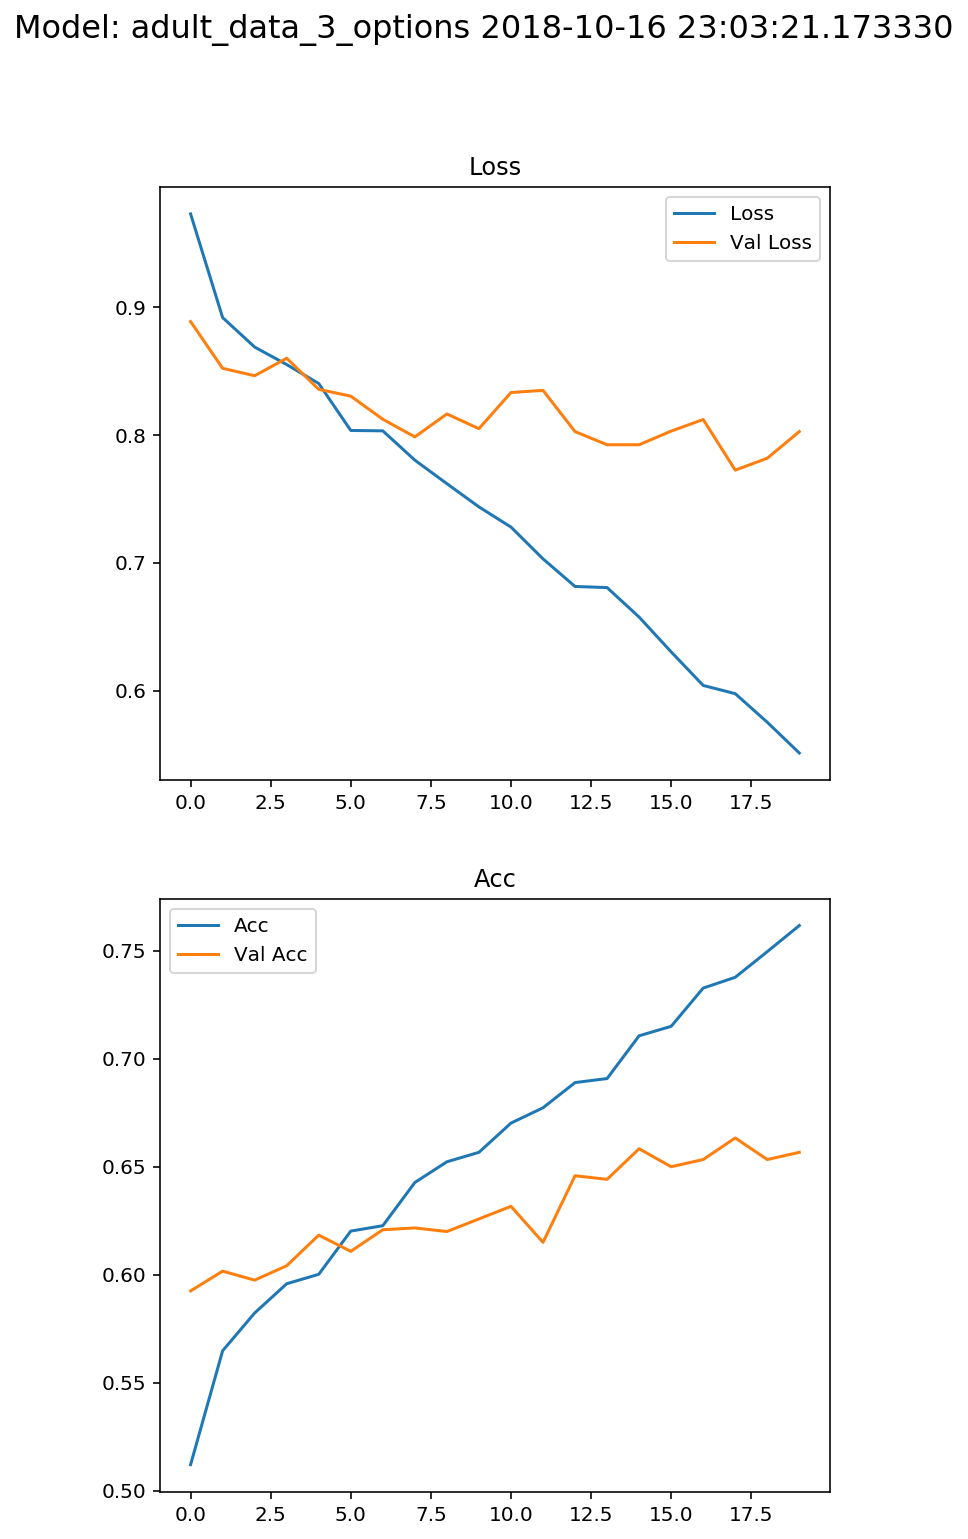

In [73]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)


In [78]:
# This shows the different levels in my NN
test_model_history.model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'clas

In [82]:
models[most_recent_model_name]['history'].model.predict(pic_df.drop(columns='class').iloc[1,:].values)

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 128, 128, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'clas

## Modeling over full adult set for 80 epochs

In [37]:
# Current Parameters
options = 2


NUM_IMAGES = adult_data.shape[0]
EPOCHS = 20
IMAGE_SIZE = (192,192)
TRAIN_SIZE = 0.8
METRICS = ['accuracy', 'mae']
BATCH_SIZE = 10
MODEL_OPTIMIZER = 'adam' #'sgd' 

if options == 2:
    CURR_MAP = y_map_2
    model_name = 'adult_data_2_options'
elif options == 3:
    CURR_MAP = y_map_3
    model_name = 'adult_data_3_options'
else:
    raise PnemoniaTargetMapIsWeird('Set "option" to 2 or 3')


In [11]:
%%time

# Load pic df if it exists, otherwise create it and save it to disk
# This isn't exactly the most hard drive storage friendly but I'm not worried about running out of harddrive space at the moment

SAVE = True #True or False

pic_df_file_name = '../data/image_dfs/pic_df-size:' + str(IMAGE_SIZE) + '-num_images:'+str(NUM_IMAGES)+'.pk'

try:
    old_pic_df = pic_df
    # Try to load the file if it exists
    file_object = open(pic_df_file_name,'rb')
    pic_df = pickle.load(file_object)
    file_object.close()
    
except:
    # This df doesn't exist already so create and save it
    pic_df = create_pic_df(adult_data, df_detailed=df_detailed, image_size=IMAGE_SIZE)
    
#     if(SAVE and sys.getsizeof(pic_df)<= 3900000000):
#         file_object = open(pic_df_file_name,'wb')
#         pickle.dump(pic_df, file_object)
#         file_object.close()

---Enter DataFrame Construction Function---
---Create Pixel Array Labels---
---Create Total Pixel Array---


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



---Create Dataframe---


OverflowError: cannot serialize a bytes object larger than 4 GiB

In [23]:
adult_data.shape, pic_df.shape

((27537, 4), (27537, 36865))

In [39]:
%%time

test_model_history, test_model_real, most_recent_model_name, model_file_path, history_file_path = model(pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, epochs=EPOCHS, train_size = TRAIN_SIZE, metrics = METRICS, batch_size=BATCH_SIZE, model_optimizer=MODEL_OPTIMIZER)



---Enter Function---


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


---Modeling Initialization---
---Modeling Training---
Train on 22029 samples, validate on 5508 samples
Epoch 1/20
22029/22029 [==============================] - 55s 2ms/step - loss: 0.5109 - acc: 0.7529 - mean_absolute_error: 0.3321 - val_loss: 0.4835 - val_acc: 0.7712 - val_mean_absolute_error: 0.3387
Epoch 2/20
22029/22029 [==============================] - 53s 2ms/step - loss: 0.4781 - acc: 0.7737 - mean_absolute_error: 0.3113 - val_loss: 0.4641 - val_acc: 0.7780 - val_mean_absolute_error: 0.3024
Epoch 3/20
22029/22029 [==============================] - 53s 2ms/step - loss: 0.4680 - acc: 0.7807 - mean_absolute_error: 0.3044 - val_loss: 0.4711 - val_acc: 0.7743 - val_mean_absolute_error: 0.3131
Epoch 4/20
22029/22029 [==============================] - 53s 2ms/step - loss: 0.4596 - acc: 0.7866 - mean_absolute_error: 0.2968 - val_loss: 0.4581 - val_acc: 0.7841 - val_mean_absolute_error: 0.3103
Epoch 5/20
22029/22029 [==============================] - 53s 2ms/step - loss: 0.4443 - acc: 

NameError: name 'model_file_name' is not defined

In [36]:
sys.getsizeof(test_model_real)

56

In [42]:
most_recent_model_name

'adult_data_2_options 2018-10-22 06:32:21.768909'

In [34]:
# Save all of the stats about each model I've run along with where the model and history objects are saved.

# Loading in the list of models/parameters
model_pickle_file_name = '../data/models/models_dict.pk'
file_object = open(model_pickle_file_name,'rb')
models_dict = pickle.load(file_object)
file_object.close()


# Add the most recent model to the list
models_dict[most_recent_model_name] = {
    'NUM_IMAGES':NUM_IMAGES,
    'model_location':model_file_path,
    'history_location':history_file_path,
    'EPOCHS':EPOCHS,
    'IMAGE_SIZE':IMAGE_SIZE,
    'Y_MAP':CURR_MAP,
    'TRAIN_SIZE':TRAIN_SIZE,
    'accuracy_scores':{}
}

for k, v in test_model_history.history.items():
    models_dict[most_recent_model_name]['accuracy_scores'][k] = v[-1]
    
#     'train':test_model_history.history['acc'][-1],
#         'test':test_model_history.history['val_acc'][-1]


# Save the list of models and parameters 
file_object = open(model_pickle_file_name,'wb')
pickle.dump(models_dict, file_object)
file_object.close()

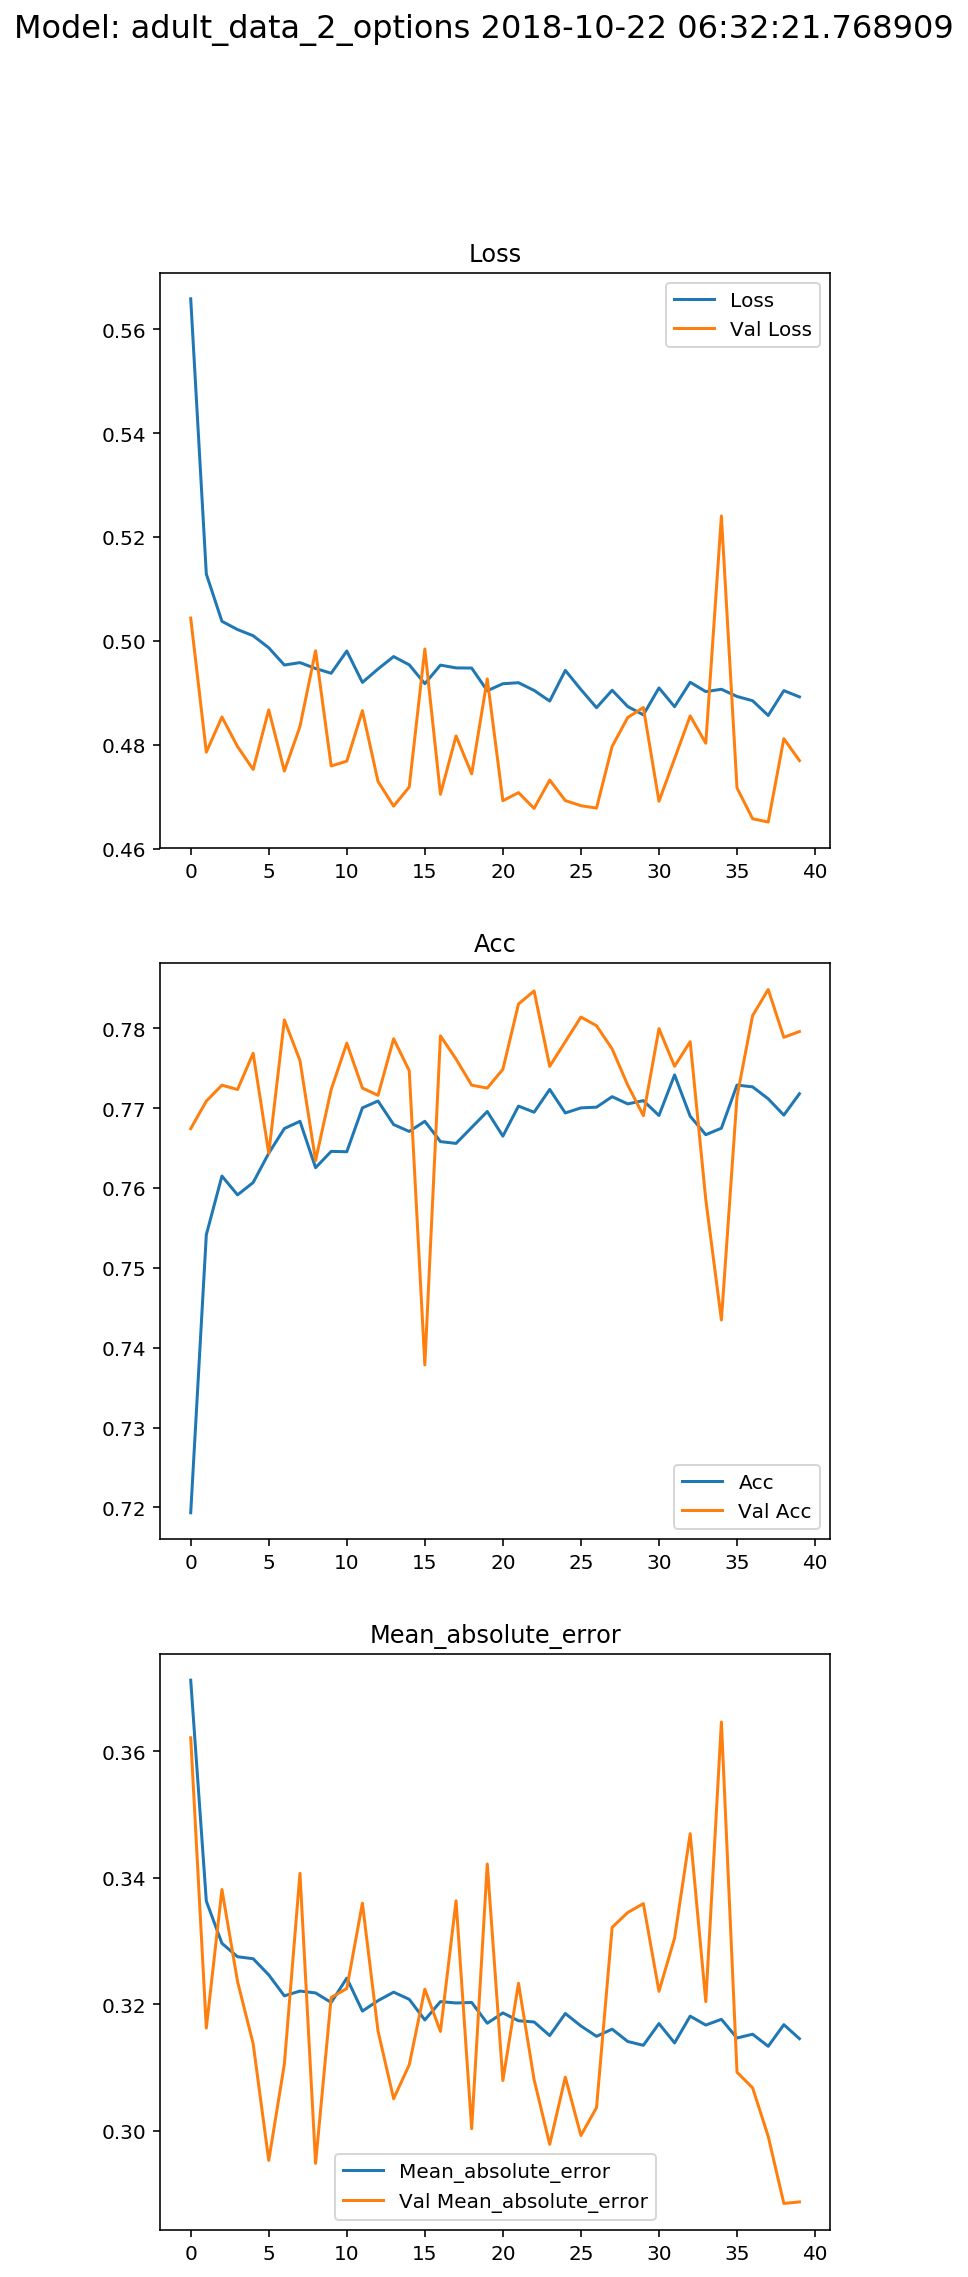

In [43]:
graph_size = 6
evaluate_model(test_model_history, most_recent_model_name, size=graph_size)


## Predicting
Creating predictions and getting useful, interpretable results from the models.

In [44]:
%%time

# Predicting on the images
X = pic_df.drop(columns='class')
pred_x = X.values.reshape(X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
preds = test_model_real.predict(pred_x)

CPU times: user 26.3 s, sys: 5.13 s, total: 31.5 s
Wall time: 31.3 s


In [45]:
# Converting the target values to the 
y_real = pic_df['class']
y_real = y_real.map(lambda x: CURR_MAP[x])

In [94]:
#preds = pd.DataFrame(data=preds, columns=[])
new_preds = []
for i in range(len(preds)):
    if preds[i][1] >= 0.20:
        prediction = 1
    else:
        prediction = 0
    new_preds.append(prediction)
print(new_preds[0:20])

[0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0]


In [56]:
# Print out the actual values against their predicted values
index = 0
for i in zip(y_real, new_preds):
    print(i)
    index+=1
    if index > 20:
        break

(0, 0)
(0, 1)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(0, 1)
(0, 0)
(0, 0)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(1, 1)
(1, 1)
(0, 0)
(1, 0)


In [72]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

In [95]:
tn, fp, fn, tp = confusion_matrix(y_real, new_preds).ravel()

In [96]:
tp / (tp + fn)

0.8482643445067398

In [97]:
fp / (fp + tn)

0.35339876788138247

In [68]:
[i[1] for i in preds]

[0.19180405,
 0.37225372,
 0.10146497,
 0.004142847,
 0.7604076,
 0.7604076,
 0.16854957,
 0.019121548,
 0.32948464,
 0.32948464,
 0.3011893,
 0.10397919,
 0.14832963,
 0.08661577,
 0.43490642,
 0.43490642,
 0.109124914,
 0.488514,
 0.488514,
 0.06939349,
 0.122974694,
 0.011701454,
 0.64692616,
 0.64692616,
 0.31003225,
 0.52385366,
 0.52385366,
 0.15175872,
 0.021957904,
 0.1095747,
 0.7865973,
 0.7865973,
 0.00061226013,
 0.0030211087,
 0.9049588,
 0.9049588,
 0.1141108,
 0.05469821,
 0.14466505,
 0.9217875,
 0.9217875,
 0.38096228,
 0.38096228,
 0.20278375,
 0.3246717,
 0.079533614,
 0.21481928,
 0.87602746,
 0.87602746,
 0.00044269508,
 0.08347933,
 0.006015436,
 0.45085773,
 0.24742858,
 0.24742858,
 0.005261965,
 0.19459695,
 0.16967171,
 0.18985419,
 0.8155692,
 0.8155692,
 0.13333434,
 0.14691672,
 0.265195,
 0.03305647,
 0.23846704,
 0.109576836,
 0.18691255,
 0.21760039,
 0.050553095,
 0.05905972,
 0.49391478,
 0.49391478,
 0.15365314,
 0.18687703,
 0.20981318,
 0.63673764,


In [69]:
roc_auc_score(y_real, [i[1] for i in preds])

0.8366763088546506

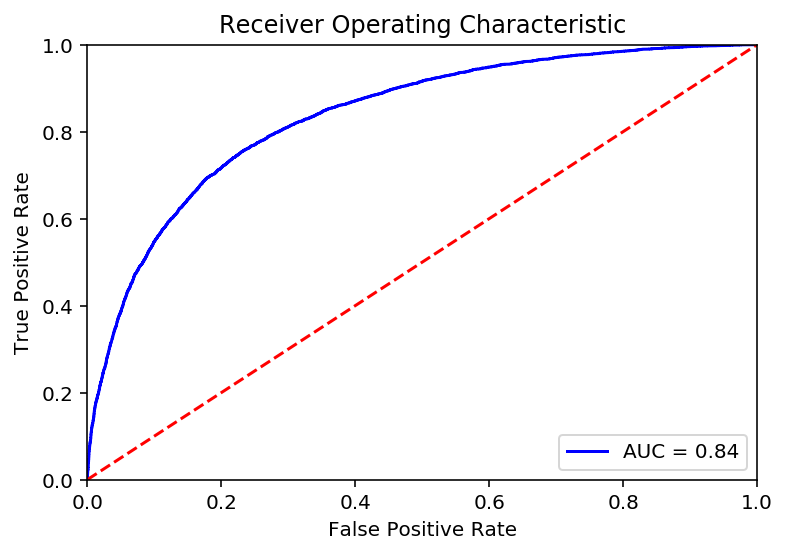

In [74]:
fpr, tpr, threshold = roc_curve(y_real, [i[1] for i in preds])
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model Comparisons

In [65]:
for k, v in models_dict.items():
    print(k+': ')
    
    for k2, v2 in v['accuracy_scores'].items():
        print(k2 + ': %.06f' % v2 )
#     print('   train: acc-%.06f' % v['accuracy_scores']['train'], end = '')
#     if(v[''])
#     print('   test: acc-%.06f' % v['accuracy_scores']['test'])

adult_data_3_options 2018-10-16 23:03:21.173330: train-0.761667   test-0.656667
adult_data_3_options 2018-10-17 03:15:52.526120: train-0.828817   test-0.685730
adult_data_3_options 2018-10-18 15:17:37.300741: train-0.742292   test-0.650833
adult_data_2_options 2018-10-18 16:00:56.383718: train-0.856458   test-0.835000
adult_data_2_options: train-0.995208   test-0.874167
adult_data_3_options: train-0.643383   test-0.656167
adult_data_3_options 2018-10-20 00:09:56.200392: train-0.889167   test-0.666667
adult_data_3_options 2018-10-20 05:32:57.594632: train-0.891458   test-0.650833
adult_data_2_options 2018-10-20 16:46:02.089673: train-0.898343   test-0.843117
adult_data_2_options 2018-10-21 05:02:16.882644: train-0.822734   test-0.803558


In [34]:


model_pickle_file_name = models_dict['adult_data_2_options 2018-10-18 16:00:56.383718']['history_location']
file_object = open(model_pickle_file_name,'rb')
model_history = pickle.load(file_object)
file_object.close()



In [37]:
model_history.model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_3',
    'trainable': True,
    'batch_input_shape': (None, 64, 64, 1),
    'dtype': 'float32',
    'filters': 6,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_3',
    'trainable': True,
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'}},
  {'class_

## What have I tried?

- Stochastic Gradient Descent had little to no positive effect on my model
- SpatialDropout2D had a negative effect on my model. I am not entirely sure what situations wuold be best for its use
- Change number of nodes per layer, amount of dropout per layer, number of filters per layer, etc. 
    - looks like more dropout was better (>=0.5)
    - no more than 2 fully connected layers necessary. Proved to have little increase (if any) in performance and added a lot of time to the training
    - I'm not sure the effect the number of filters had

## What am I trying to do now?

- change model dict to incorporate all metrics tested against
- implement a gridsearch / gridsearch-type structure 
- create new datasets with certain parameters
    - balanced classes with respect to sex, position, age, target
        - 2 versions, one with pneumonia/not_pneumonia balanced and one with normal/abnormal/pneumonia balanced
    - a mini-training set of maybe 5k images and a full training set using all of our images 
        - 3 versions of our "full data" one: one with undersampling of normal/abnormal/not pneumonia, one with oversampling of pneumonia, and one with just the full data we have

## Further down the line

- Try to get bounding boxes - [R-CNN (or a different iteration)](https://heartbeat.fritz.ai/the-5-computer-vision-techniques-that-will-change-how-you-see-the-world-1ee19334354b)
- 

## Continuing to Train Models

In [71]:
%%time

test_model_history, test_model_real, most_recent_model_name, model_file_path, history_file_path = continue_training(test_model_real, pic_df.head(NUM_IMAGES), model_name = model_name, image_size=IMAGE_SIZE, y_map=CURR_MAP, epochs=80, train_size = TRAIN_SIZE, metrics = METRICS, batch_size=BATCH_SIZE, model_optimizer=MODEL_OPTIMIZER)



/home/ec2-user/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 22029 samples, validate on 5508 samples
Epoch 1/80
22029/22029 [==============================] - 228s 10ms/step - loss: 0.4011 - acc: 0.8287 - mean_absolute_error: 0.2475 - val_loss: 0.4370 - val_acc: 0.8003 - val_mean_absolute_error: 0.2970
Epoch 2/80
22029/22029 [==============================] - 230s 10ms/step - loss: 0.4037 - acc: 0.8250 - mean_absolute_error: 0.2524 - val_loss: 0.4383 - val_acc: 0.7974 - val_mean_absolute_error: 0.2834
Epoch 3/80
22029/22029 [==============================] - 226s 10ms/step - loss: 0.4060 - acc: 0.8238 - mean_absolute_error: 0.2524 - val_loss: 0.4334 - val_acc: 0.7968 - val_mean_absolute_error: 0.2882
Epoch 4/80
22029/22029 [==============================] - 226s 10ms/step - loss: 0.4041 - acc: 0.8248 - mean_absolute_error: 0.2507 - val_loss: 0.4298 - val_acc: 0.8112 - val_mean_absolute_error: 0.2868
Epoch 5/80
22029/22029 [==============================] - 230s 10ms/step - loss: 0.3972 - acc: 0.8308 - mean_absolute_error: 0.2466 - val_l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 232s 11ms/step - loss: 0.4002 - acc: 0.8275 - mean_absolute_error: 0.2482 - val_loss: 0.4314 - val_acc: 0.8052 - val_mean_absolute_error: 0.2886
Epoch 21/80
 8900/22029 [===========>..................] - ETA: 2:07 - loss: 0.3971 - acc: 0.8274 - mean_absolute_error: 0.2484

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 226s 10ms/step - loss: 0.3984 - acc: 0.8304 - mean_absolute_error: 0.2472 - val_loss: 0.4374 - val_acc: 0.7999 - val_mean_absolute_error: 0.2762
Epoch 23/80
20440/22029 [==========================>...] - ETA: 15s - loss: 0.4032 - acc: 0.8271 - mean_absolute_error: 0.2499

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 232s 11ms/step - loss: 0.4017 - acc: 0.8290 - mean_absolute_error: 0.2488 - val_loss: 0.4458 - val_acc: 0.7907 - val_mean_absolute_error: 0.2723
Epoch 25/80
22029/22029 [==============================] - 230s 10ms/step - loss: 0.4037 - acc: 0.8267 - mean_absolute_error: 0.2491 - val_loss: 0.4347 - val_acc: 0.8046 - val_mean_absolute_error: 0.2818
Epoch 26/80
 5590/22029 [======>.......................] - ETA: 2:38 - loss: 0.3955 - acc: 0.8309 - mean_absolute_error: 0.2450

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 231s 10ms/step - loss: 0.3993 - acc: 0.8277 - mean_absolute_error: 0.2481 - val_loss: 0.4450 - val_acc: 0.8028 - val_mean_absolute_error: 0.2663
Epoch 28/80
16950/22029 [======================>.......] - ETA: 48s - loss: 0.4004 - acc: 0.8277 - mean_absolute_error: 0.2487

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 225s 10ms/step - loss: 0.4010 - acc: 0.8279 - mean_absolute_error: 0.2491 - val_loss: 0.4542 - val_acc: 0.7939 - val_mean_absolute_error: 0.2619
Epoch 30/80
22029/22029 [==============================] - 226s 10ms/step - loss: 0.4013 - acc: 0.8273 - mean_absolute_error: 0.2492 - val_loss: 0.4394 - val_acc: 0.7976 - val_mean_absolute_error: 0.2909
Epoch 31/80
 6310/22029 [=======>......................] - ETA: 2:32 - loss: 0.3988 - acc: 0.8258 - mean_absolute_error: 0.2468

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 229s 10ms/step - loss: 0.3957 - acc: 0.8307 - mean_absolute_error: 0.2462 - val_loss: 0.4290 - val_acc: 0.8083 - val_mean_absolute_error: 0.2778
Epoch 33/80
13470/22029 [=================>............] - ETA: 1:22 - loss: 0.4057 - acc: 0.8272 - mean_absolute_error: 0.2516

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 230s 10ms/step - loss: 0.4038 - acc: 0.8262 - mean_absolute_error: 0.2504 - val_loss: 0.4276 - val_acc: 0.8092 - val_mean_absolute_error: 0.2758
Epoch 35/80
22029/22029 [==============================] - 228s 10ms/step - loss: 0.4012 - acc: 0.8292 - mean_absolute_error: 0.2490 - val_loss: 0.4265 - val_acc: 0.8094 - val_mean_absolute_error: 0.2686
Epoch 36/80
 2950/22029 [===>..........................] - ETA: 3:04 - loss: 0.3715 - acc: 0.8458 - mean_absolute_error: 0.2283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 230s 10ms/step - loss: 0.3969 - acc: 0.8278 - mean_absolute_error: 0.2471 - val_loss: 0.4344 - val_acc: 0.8059 - val_mean_absolute_error: 0.2875
Epoch 38/80
14440/22029 [==================>...........] - ETA: 1:13 - loss: 0.3968 - acc: 0.8321 - mean_absolute_error: 0.2465

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 227s 10ms/step - loss: 0.4014 - acc: 0.8274 - mean_absolute_error: 0.2487 - val_loss: 0.4291 - val_acc: 0.8023 - val_mean_absolute_error: 0.2787
Epoch 40/80
22029/22029 [==============================] - 227s 10ms/step - loss: 0.3973 - acc: 0.8295 - mean_absolute_error: 0.2448 - val_loss: 0.4389 - val_acc: 0.7999 - val_mean_absolute_error: 0.2975
Epoch 41/80
 3960/22029 [====>.........................] - ETA: 2:56 - loss: 0.3836 - acc: 0.8447 - mean_absolute_error: 0.2405

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 227s 10ms/step - loss: 0.3993 - acc: 0.8271 - mean_absolute_error: 0.2473 - val_loss: 0.4621 - val_acc: 0.7745 - val_mean_absolute_error: 0.3145
Epoch 43/80
15550/22029 [====================>.........] - ETA: 1:02 - loss: 0.4029 - acc: 0.8320 - mean_absolute_error: 0.2493

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 227s 10ms/step - loss: 0.3972 - acc: 0.8309 - mean_absolute_error: 0.2455 - val_loss: 0.4332 - val_acc: 0.8039 - val_mean_absolute_error: 0.2830
Epoch 45/80
22029/22029 [==============================] - 226s 10ms/step - loss: 0.3996 - acc: 0.8290 - mean_absolute_error: 0.2484 - val_loss: 0.4355 - val_acc: 0.8005 - val_mean_absolute_error: 0.2613
Epoch 46/80
 5110/22029 [=====>........................] - ETA: 2:41 - loss: 0.4067 - acc: 0.8205 - mean_absolute_error: 0.2526

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 225s 10ms/step - loss: 0.3992 - acc: 0.8317 - mean_absolute_error: 0.2473 - val_loss: 0.4359 - val_acc: 0.7996 - val_mean_absolute_error: 0.2895
Epoch 48/80
16330/22029 [=====================>........] - ETA: 55s - loss: 0.3980 - acc: 0.8281 - mean_absolute_error: 0.2475

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 225s 10ms/step - loss: 0.3994 - acc: 0.8275 - mean_absolute_error: 0.2483 - val_loss: 0.4301 - val_acc: 0.8048 - val_mean_absolute_error: 0.2762
Epoch 50/80
22029/22029 [==============================] - 226s 10ms/step - loss: 0.3993 - acc: 0.8300 - mean_absolute_error: 0.2468 - val_loss: 0.4362 - val_acc: 0.8017 - val_mean_absolute_error: 0.2851
Epoch 51/80
 5830/22029 [======>.......................] - ETA: 2:37 - loss: 0.4049 - acc: 0.8269 - mean_absolute_error: 0.2523

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 227s 10ms/step - loss: 0.4022 - acc: 0.8300 - mean_absolute_error: 0.2479 - val_loss: 0.4345 - val_acc: 0.8025 - val_mean_absolute_error: 0.2902
Epoch 53/80
11750/22029 [===============>..............] - ETA: 1:38 - loss: 0.3987 - acc: 0.8289 - mean_absolute_error: 0.2488

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 230s 10ms/step - loss: 0.3978 - acc: 0.8292 - mean_absolute_error: 0.2464 - val_loss: 0.4321 - val_acc: 0.8041 - val_mean_absolute_error: 0.2778
Epoch 55/80
22029/22029 [==============================] - 230s 10ms/step - loss: 0.3987 - acc: 0.8292 - mean_absolute_error: 0.2473 - val_loss: 0.4485 - val_acc: 0.8007 - val_mean_absolute_error: 0.2550
Epoch 56/80
  690/22029 [..............................] - ETA: 3:28 - loss: 0.4377 - acc: 0.8101 - mean_absolute_error: 0.2627

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 224s 10ms/step - loss: 0.3983 - acc: 0.8294 - mean_absolute_error: 0.2464 - val_loss: 0.4325 - val_acc: 0.8076 - val_mean_absolute_error: 0.2925
Epoch 58/80
11950/22029 [===============>..............] - ETA: 1:35 - loss: 0.4042 - acc: 0.8258 - mean_absolute_error: 0.2507

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 229s 10ms/step - loss: 0.4053 - acc: 0.8259 - mean_absolute_error: 0.2522 - val_loss: 0.4454 - val_acc: 0.7996 - val_mean_absolute_error: 0.3081
Epoch 60/80
22029/22029 [==============================] - 228s 10ms/step - loss: 0.4065 - acc: 0.8244 - mean_absolute_error: 0.2514 - val_loss: 0.4365 - val_acc: 0.8066 - val_mean_absolute_error: 0.2900
Epoch 61/80
 1220/22029 [>.............................] - ETA: 3:18 - loss: 0.3861 - acc: 0.8344 - mean_absolute_error: 0.2418

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 228s 10ms/step - loss: 0.4056 - acc: 0.8239 - mean_absolute_error: 0.2526 - val_loss: 0.4411 - val_acc: 0.8023 - val_mean_absolute_error: 0.3015
Epoch 63/80
12780/22029 [================>.............] - ETA: 1:29 - loss: 0.3984 - acc: 0.8279 - mean_absolute_error: 0.2473

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 225s 10ms/step - loss: 0.3986 - acc: 0.8319 - mean_absolute_error: 0.2458 - val_loss: 0.4357 - val_acc: 0.8036 - val_mean_absolute_error: 0.2927
Epoch 65/80
18300/22029 [=======================>......] - ETA: 35s - loss: 0.3917 - acc: 0.8330 - mean_absolute_error: 0.2422

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 226s 10ms/step - loss: 0.3977 - acc: 0.8301 - mean_absolute_error: 0.2460 - val_loss: 0.4352 - val_acc: 0.8030 - val_mean_absolute_error: 0.2800
Epoch 67/80
22029/22029 [==============================] - 225s 10ms/step - loss: 0.3965 - acc: 0.8309 - mean_absolute_error: 0.2460 - val_loss: 0.4425 - val_acc: 0.8001 - val_mean_absolute_error: 0.2942
Epoch 68/80
 7540/22029 [=========>....................] - ETA: 2:17 - loss: 0.3938 - acc: 0.8353 - mean_absolute_error: 0.2429

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 225s 10ms/step - loss: 0.3991 - acc: 0.8269 - mean_absolute_error: 0.2477 - val_loss: 0.4491 - val_acc: 0.7981 - val_mean_absolute_error: 0.2734
Epoch 70/80
18790/22029 [========================>.....] - ETA: 31s - loss: 0.4034 - acc: 0.8243 - mean_absolute_error: 0.2511

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 228s 10ms/step - loss: 0.3962 - acc: 0.8302 - mean_absolute_error: 0.2443 - val_loss: 0.4522 - val_acc: 0.7994 - val_mean_absolute_error: 0.2787
Epoch 73/80
 8090/22029 [==========>...................] - ETA: 2:14 - loss: 0.3954 - acc: 0.8334 - mean_absolute_error: 0.2442

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 226s 10ms/step - loss: 0.4017 - acc: 0.8265 - mean_absolute_error: 0.2490 - val_loss: 0.4386 - val_acc: 0.8017 - val_mean_absolute_error: 0.2754
Epoch 75/80
19520/22029 [=========================>....] - ETA: 24s - loss: 0.4041 - acc: 0.8251 - mean_absolute_error: 0.2516

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 229s 10ms/step - loss: 0.4008 - acc: 0.8290 - mean_absolute_error: 0.2472 - val_loss: 0.4531 - val_acc: 0.7974 - val_mean_absolute_error: 0.2635
Epoch 78/80
 9220/22029 [===========>..................] - ETA: 2:04 - loss: 0.3973 - acc: 0.8315 - mean_absolute_error: 0.2460

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22029/22029 [==============================] - 229s 10ms/step - loss: 0.4019 - acc: 0.8266 - mean_absolute_error: 0.2490 - val_loss: 0.4340 - val_acc: 0.8043 - val_mean_absolute_error: 0.2734
Epoch 80/80
20850/22029 [===========================>..] - ETA: 11s - loss: 0.3936 - acc: 0.8321 - mean_absolute_error: 0.2439

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [102]:
patientId = adult_data['patientId'].iloc[2]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 191.5, 191.5, -0.5)

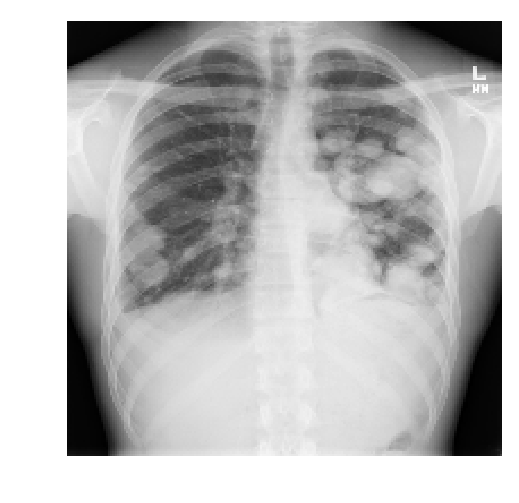

In [106]:
dcm_file = '../data/stage_1_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
im = resize(dcm_data.pixel_array, (192, 192))

pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')